# Bayesian Networks are Decision Making Tools
**David S. Fulford**  
*February, 2020*

Bayesian networks are useful tools for prediction/imputing values of missing or hidden/latent variables. These problems arise frequently in data analysis where samples may be missing certain variables, or certain variables are measured from sensors that display an inordinate amount of noise.

The [Monty Hall Problem](https://en.wikipedia.org/wiki/Monty_Hall_problem) is a simple problem in which we desire to choose one of three doors that contains a prize. The only information we have is that the door containing the prize is completely random&mdash;that is, it is equally likely to be behind either of the three doors&mdash; and Monty will choose a door that is not the door the guest has chosen, or the door with the prize behind.

From this information, we must then choose which door to open. The game is framed to the player as "would you like to switch doors?" to take advantage of the [endowment effect](https://en.wikipedia.org/wiki/Endowment_effect). As we'll see, it is ***always*** better to switch, while the game frames the player to desire to never switch. It's important to understand the prior probabilties, and how the information gain changes those probabilities, to act against our desire to stick with our original choice.

In [1]:
import numpy as np
import pomegranate as pg

import daft
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

#### Import the libraries we'll be using.

* [Numpy](https://numpy.org/) is one of the fundamental packages for Python that provides access to powerful functions for working with arrays.
* [Pandas](https://pandas.io/) is a library for constructing column-heterogenous typed arrays, or data frames. This is only used for a convenient HTML representation of some data items.
* [Pomegranate](https://pomegranate.readthedocs.io/en/latest/index.html) is the only library we need to run the Bayesian Network.
* [Daft](https://docs.daft-pgm.org/en/latest/) is a library used to render graphical models that does not require installation of any additional software. Although Pomegranata can render its networks using GraphViz, GraphViz and PyGraphViz must exist on the system, and the installation on Windows is not well supported. Full disclosure, I became a primary maintainer of this package because I find it so useful. [View the PGM used in my Master's thesis here!](https://docs.daft-pgm.org/en/latest/examples/deconvolution/)
* [Matplotlib](https://matplotlib.org/) is our standard plotting package, and is used by Daft in this example.

We'll display the network first.

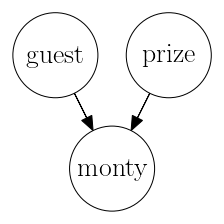

In [2]:
import daft
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 28
mpl.rcParams['text.usetex'] = True

scale = 3
# Instantiate the PGM.
pgm = daft.PGM()

# Hierarchical parameters.
pgm.add_node('s1', 'guest', 1, 0, scale)
pgm.add_node('s2', 'prize', 3, 0, scale)
pgm.add_node('s3', 'monty', 2, -2, scale)

# Add in the edges.
arrow={'head_width':.4, 'head_length':.5}
pgm.add_edge('s1', 's3', plot_params=arrow)
pgm.add_edge('s2', 's3', plot_params=arrow)

# Render.
pgm.show()

The door the guest chooses, and the door hiding the prize, are not dependent on any other variable. We'll assume a uniform distribution for each (1/3 chance of each of the three doors).

The choice by Monty is a dependent upon both the guest's choice and the prize door, so we construct a conditional probability table.

The visualization of the graph tells us how information flows in the network. For example, until we know what door Monty has chosen, we do not have any information to relate `guest` to `prize`. We say that these variables are ***conditionally indepedent***. Both are represented by uniform distributions.

Once we have observed `monty`, *then* the path between `guest` and `prize` is active through `monty` &mdash; `guest` and `prize` are no longer independent. Then, given that we only know `guest` and `monty` we could make a posterior prediction for `prize`. The network influence would flow like this:

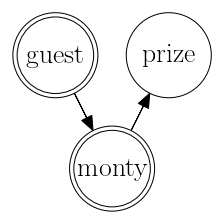

In [3]:
pgm = daft.PGM(observed_style='inner')
pgm.add_node('s1', 'guest', 1, 0, scale, observed=True); pgm.add_node('s2', 'prize', 3, 0, scale); \
    pgm.add_node('s3', 'monty', 2, -2, scale, observed=True)
pgm.add_edge('s1', 's3', plot_params=arrow); pgm.add_edge('s3', 's2', plot_params=arrow)
pgm.show()

First, we build the network.
 - `guest` has a conditionally indepedent uniform distribution
 - `prize` has a conditionally indepedent uniform distribution
 - `monty` has a conditional distribution defined by the rules of the game (Monty will open a door that is not chosen by the guest and does not have the prize behind it)
 
 We define distributions for the conditionally independent variables:

In [4]:
# Define Distributions
guest = pg.DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})
prize = pg.DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})

Now, we build the conditional probability table based upon the rules of the game:

In [5]:
doors = ['A', 'B', 'C']
m_count = []
for g in doors:
    for p in doors:
        t_count = 0
        # Loop through and count total possible outcomes for P(monty | guest, prize)
        for m in doors:
            if m != g and m != p:
                # Monty can remove a door not picked by guest and not hiding a prize
                t_count += 1
        # Loop through and calculate conditional probability P(monty | guest, prize)
        for m in doors:
            if m != g and m != p:
                # Monty can remove a door not picked by guest and not hiding a prize
                m_count.append([g, p, m, 1. / t_count])
            else:
                m_count.append([g, p, m, 0.])

monty = pg.ConditionalProbabilityTable(
    m_count, [guest, prize])

m_count

[['A', 'A', 'A', 0.0],
 ['A', 'A', 'B', 0.5],
 ['A', 'A', 'C', 0.5],
 ['A', 'B', 'A', 0.0],
 ['A', 'B', 'B', 0.0],
 ['A', 'B', 'C', 1.0],
 ['A', 'C', 'A', 0.0],
 ['A', 'C', 'B', 1.0],
 ['A', 'C', 'C', 0.0],
 ['B', 'A', 'A', 0.0],
 ['B', 'A', 'B', 0.0],
 ['B', 'A', 'C', 1.0],
 ['B', 'B', 'A', 0.5],
 ['B', 'B', 'B', 0.0],
 ['B', 'B', 'C', 0.5],
 ['B', 'C', 'A', 1.0],
 ['B', 'C', 'B', 0.0],
 ['B', 'C', 'C', 0.0],
 ['C', 'A', 'A', 0.0],
 ['C', 'A', 'B', 1.0],
 ['C', 'A', 'C', 0.0],
 ['C', 'B', 'A', 1.0],
 ['C', 'B', 'B', 0.0],
 ['C', 'B', 'C', 0.0],
 ['C', 'C', 'A', 0.5],
 ['C', 'C', 'B', 0.5],
 ['C', 'C', 'C', 0.0]]

In [6]:
# Initialize model
model = pg.BayesianNetwork('Monty Hall Problem')

# Define nodes
s1 = pg.Node(guest, name='guest')
s2 = pg.Node(prize, name='prize')
s3 = pg.Node(monty, name='monty')

# Add edges
model.add_states(s1, s2, s3)
model.add_edge(s1, s3)
model.add_edge(s2, s3)

# Build model
model.bake()

#### Marginal Probabilties
We can evaluate the marginal probability of Monty's choice given the guest and prize variables First, let's verify we have a proper prior marginal for Monty's choice computed from our conditional probability table:

In [7]:
model.marginal()[2].parameters

[{'C': 0.3333333333333333, 'A': 0.3333333333333333, 'B': 0.3333333333333333}]

Which is correct!

Now, show the marginal probability of specific outcomes:

In [8]:
# a bug in the current version requires (0.12.0) conversion to numpy array
print('Passing a single outcome:')
display(model.probability(np.atleast_2d(['A', 'A', 'B'])))

print('\nPassing multiple outcomes:\n')
print(model.probability(np.array([
    ['A', 'A', 'B'],
    ['A', 'A', 'B'],
    ['A', 'A', 'C'],
    ['C', 'C', 'B'],
])).reshape(-1, 1))

Passing a single outcome:


0.05555555555555554


Passing multiple outcomes:

[[0.05555556]
 [0.05555556]
 [0.05555556]
 [0.05555556]]


#### Prediction
We're more interested in the prediction given a missing variable, however. Here we can make a prediction for the door Monty will pick given a door chosen by the guest, and the door hiding the prize.

In [9]:
display(model.predict([
    ['A', 'B', None],
    ['A', 'C', None],
    ['B', 'A', None],
    ['B', 'C', None],
    ['C', 'A', None],
    ['C', 'B', None]
]))

[array(['A', 'B', 'C'], dtype=object),
 array(['A', 'C', 'B'], dtype=object),
 array(['B', 'A', 'C'], dtype=object),
 array(['B', 'C', 'A'], dtype=object),
 array(['C', 'A', 'B'], dtype=object),
 array(['C', 'B', 'A'], dtype=object)]

#### Should we switch doors?

In the case of the Monty Hall problem, we want to predict the door containing the prize *given* our first choice, and Monty's choice, as we do not know which door is hiding the prize. This is the Bayesian problem, where we desired to ***invert*** our graph:

In [10]:
display(model.predict([
    ['A', None, 'B'],
    ['A', None, 'C'],
    ['B', None, 'A'],
    ['B', None, 'C'],
    ['C', None, 'A'],
    ['C', None, 'B']
]))

[array(['A', 'C', 'B'], dtype=object),
 array(['A', 'B', 'C'], dtype=object),
 array(['B', 'C', 'A'], dtype=object),
 array(['B', 'A', 'C'], dtype=object),
 array(['C', 'B', 'A'], dtype=object),
 array(['C', 'A', 'B'], dtype=object)]

The interpretation of the predictions is that it is *always* better to switch the door once Monty makes his choice! We can also look at the probabilities of each value as opposed to just the prediction. This is known as ***marginalization***, in which we "marginalize out" the observed variables. Mathematically, we sum (or integrate) the outcomes from our conditional probability table for the unobserved variables *over* the subset of outcomes which match the observed variables.

In [11]:
print('Show Probabilities for each door:')
display(model.predict_proba({'guest':'A', 'monty':'B'})[1].parameters)

print('\n Where the maximum likelihood matches the prediction:')
display(model.predict([['A', None, 'B']])[0][1])

Show Probabilities for each door:


[{'A': 0.3333333333333334, 'B': 0.0, 'C': 0.6666666666666664}]


 Where the maximum likelihood matches the prediction:


'C'

### Example Game

Let's show an example of the game. The Guest chooses door 1, while door 2 has the prize. We know that:
- There is a 33.3% chance the prize is behind the door chosen.
- There is a 66.6% chance the prize is behind a door not chosen.

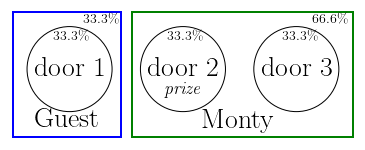

In [12]:
pgm = daft.PGM()
pgm.add_node('d1', 'door 1', 1, 1, scale); pgm.add_node('d2', 'door 2', 3, 1, scale); pgm.add_node('d3', 'door 3', 5, 1, scale)
pgm.add_plate([0, 0, 1.9, 2], label='Guest', shift=-0.2, label_offset=[22.5, 5], rect_params={'lw':2, 'ec':'b'})
pgm.add_plate([2.1, 0, 3.9, 2], label='Monty', shift=-0.2, label_offset=[22.5*2+25, 5], rect_params={'lw':2, 'ec':'g'})
pgm.add_plate([2.1, 0, 3.9, 2], label=r'\it prize', shift=-0.2, label_offset=[32.5, 40], fontsize=18, rect_params={'ec':None})
pgm.add_plate([0, 0, 1.9, 2], label='33.3\%', shift=-0.2, label_offset=[40, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([0, 0, 1.9, 2], label='33.3\%', shift=-0.2, label_offset=[70, 112], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='33.3\%', shift=-0.2, label_offset=[35, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='33.3\%', shift=-0.2, label_offset=[150, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='66.6\%', shift=-0.2, label_offset=[180, 112], fontsize=14, rect_params={'ec':None})
pgm.show()

Based upon the rules of the game, Monty **must** choose door 3 and reveal no prize behind it. 

- There is still a 33.3% chance the prize is behind the door chosen.
- There is still a 66.6% chance the prize is behind a door not chosen.

However, because Monty's choice is not random&mdash; he cannot choose the door with a prize behind it&mdash; we can exploit our knowledge and conclude that door 2 must inherit the probability from door 3.

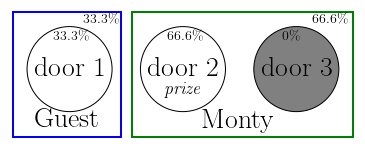

In [13]:
pgm = daft.PGM()
pgm.add_node('d1', 'door 1', 1, 1, scale); pgm.add_node('d2', r'door 2', 3, 1, scale); pgm.add_node('d3', 'door 3', 5, 1, scale, plot_params={'fc':'grey'})
pgm.add_plate([0, 0, 1.9, 2], label='Guest', shift=-0.2, label_offset=[22.5, 5], rect_params={'lw':2, 'ec':'b'})
pgm.add_plate([2.1, 0, 3.9, 2], label='Monty', shift=-0.2, label_offset=[22.5*2+25, 5], rect_params={'lw':2, 'ec':'g'})
pgm.add_plate([2.1, 0, 3.9, 2], label=r'\it prize', shift=-0.2, label_offset=[32.5, 40], fontsize=18, rect_params={'ec':None})
pgm.add_plate([0, 0, 1.9, 2], label='33.3\%', shift=-0.2, label_offset=[40, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([0, 0, 1.9, 2], label='33.3\%', shift=-0.2, label_offset=[70, 112], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='66.6\%', shift=-0.2, label_offset=[35, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='0\%', shift=-0.2, label_offset=[150, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='66.6\%', shift=-0.2, label_offset=[180, 112], fontsize=14, rect_params={'ec':None})
pgm.show()

And to use our Bayesian Network: 

In [14]:
display(model.predict_proba({'guest': 'A', 'monty':'C'})[1].parameters)

[{'A': 0.3333333333333334, 'B': 0.6666666666666664, 'C': 0.0}]

We can easily compute the posterior probability, and use the maximum likelihood to make a prediction.

Bayesian Networks allow us to encode known rules, logic, and relations into a system, and provides us with a prediction that incorporates all available information!

## Bayesian Belief Network

What is a Bayesian Belief Network? It's the same thing as a Bayesian Network, actually. It's just a more formal name. But, for our purposes, let's imagine that the difference exists as one *semantics*, viz. a Bayesian Belief Network accounts for a node that encodes how much we should trust or believe a second node. Mathematically, this is no different, but the idea is very powerful.

Bayesian Belief Networks are applied to real-time classification systems such as the state of a drilling rig. They require no training, only exact enumeration of possible states, and the observed combination of those states. I've already showed how one might generate the list of all possible states from a given set of inputs. While these do become quite long lists due to the properties of combinatorics, constructing this is very straight forward and can be generalized programmatically.

Let's extend our Monty Hall problem to include the ability for the show's audience to give a guess. We'll make up a number for the accuracy of the audience's guess... let's say 75% of the time, they pick the **wrong** door.

*(Breaking the fourth wall: Why make this arbitrary choice? Because we'll see, just because we expect them to be wrong, doesn't mean we should not listen to them! The crowd isn't the only source of information, and that makes all the difference.)*

We need to extend our table of possible states to account for this fourth state. But hold on... should our person ask the crowd, or even trust their answer? In a real game show, the contestant may choose to ask or trust the crowd, or not. How do we encode this information?

Let's simplify and say that, if our contestant asks the crowd, they would listen to the crowd, and always pick the crowd's answer. Otherwise, the state of our game would not change... if the crowd is not asked, then the information is not considered. But, the crowd has a guess no matter whether the contestant asks them or not. How do we both know the crowd's guess, but only conditionally listen to it? (Hint: the key word here is *conditionally*)

We need to answer two questions:

1. What is the crowd's guess. This is dependent upon the result of where the prize is.
2. Should the contestant ask the crowd?

While it may seem like we need to construct a complex state machine to handle two entirely different models: one in which we listen to the crowd and include their information/guess, and one in which we do not. In actuality, we do not need to worry about state at all! Remember that we describe outcomes that occur only **conditionally** given other outcomes. Meaning, we can just reason about what the crowd's guess would be indepedent of the contestant's guess!

First, let's visualize this network.

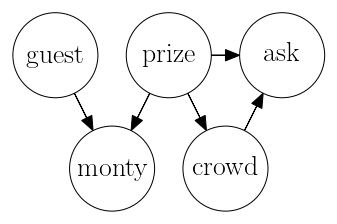

In [15]:
import daft
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 28
mpl.rcParams['text.usetex'] = True

scale = 3
# Instantiate the PGM.
pgm = daft.PGM()

# Hierarchical parameters.
pgm.add_node('s1', 'guest', 1, 0, scale)
pgm.add_node('s2', 'prize', 3, 0, scale)
pgm.add_node('s3', 'monty', 2, -2, scale)
pgm.add_node('s4', 'crowd', 4, -2, scale)
pgm.add_node('s5', 'ask', 5, 0, scale)

# Add in the edges.
arrow={'head_width':.4, 'head_length':.5}
pgm.add_edge('s1', 's3', plot_params=arrow)
pgm.add_edge('s2', 's3', plot_params=arrow)
pgm.add_edge('s4', 's5', plot_params=arrow)
pgm.add_edge('s2', 's5', plot_params=arrow)
pgm.add_edge('s2', 's4', plot_params=arrow)

# Render.
pgm.show()

We've drawn the network this way to highlight the key feature of probabilistic graphical models. This feature is **conditional independence**, and it can be directly observed from the structure of the graph. Influence in a directed graph only flows in the backwards when the downstream variable is observed. This means that, the marginal distribution for the `crowd` is/must/ought to be uninformative. In fact, the `ask` node is not even needed, but we've added it for use we'll address later.

If the contestant does not ask the crowd, we just treat `crowd` as unobserved, and let the math take care of itself. No need to change anything in the existing conditional probability tables at all.

Let's populate the `crowd` table. The crowd guesses wrong 75% of the time, so we need to represent that. As we saw in the first example, once an option is removed, the probability of that option isn't removed from play. So, we don't need to make this table conditional upon Monty's choice, even though the crowd may only be asked at that point. The probability of 12.5% that is assigned to the the door that is taken away will be "inherited" by the remaining incorrect door.

In [16]:
# Crowd's guess given actual door with prize
crowd_acc = 0.25

c_count = []
for p in doors:
    for c in doors:
        if c == p:
            c_count.append([p, c, crowd_acc])
        else:             
            c_count.append([p, c, (1 - crowd_acc) / 2])

crowd = pg.ConditionalProbabilityTable(
    c_count, [prize])

c_count

[['A', 'A', 0.25],
 ['A', 'B', 0.375],
 ['A', 'C', 0.375],
 ['B', 'A', 0.375],
 ['B', 'B', 0.25],
 ['B', 'C', 0.375],
 ['C', 'A', 0.375],
 ['C', 'B', 0.375],
 ['C', 'C', 0.25]]

What about that `ask` node? Well, it's useful to infer whether we should ask the crowd for their answer, given the contestant's guess and Monty's choice of which door to remove. This node will be used to tell us that. We define it just as whether the crowd guessed correctly.

In [17]:
# Is the crowd right?
a_count = []
for p in doors:
    for c in doors:
        for a in ['Y', 'N']:
            if c == p:
                a_count.append([p, c, a, int(a == 'Y')])              
            else:             
                a_count.append([p, c, a, int(a == 'N')])

asked = pg.ConditionalProbabilityTable(
    a_count, [prize, crowd])

a_count

[['A', 'A', 'Y', 1],
 ['A', 'A', 'N', 0],
 ['A', 'B', 'Y', 0],
 ['A', 'B', 'N', 1],
 ['A', 'C', 'Y', 0],
 ['A', 'C', 'N', 1],
 ['B', 'A', 'Y', 0],
 ['B', 'A', 'N', 1],
 ['B', 'B', 'Y', 1],
 ['B', 'B', 'N', 0],
 ['B', 'C', 'Y', 0],
 ['B', 'C', 'N', 1],
 ['C', 'A', 'Y', 0],
 ['C', 'A', 'N', 1],
 ['C', 'B', 'Y', 0],
 ['C', 'B', 'N', 1],
 ['C', 'C', 'Y', 1],
 ['C', 'C', 'N', 0]]

That's it! We don't need to change anything else, because nothing in the first place has any conditional dependency upon our new nodes. Which is pretty cool... we can just add on new nodes, and we only need to specify the **conditional distributions**, not manage the global state.  Bayes' Thereom takes care of the rest!

In [18]:
# Initialize model2
model2 = pg.BayesianNetwork('Monty Hall Problem')

# Define nodes
s1 = pg.Node(guest, name='guest')
s2 = pg.Node(prize, name='prize')
s3 = pg.Node(monty, name='monty')
s4 = pg.Node(crowd, name='crowd')
s5 = pg.Node(asked, name='asked')

# Add edges
model2.add_states(s1, s2, s3, s4, s5)
# model2.add_states(s1, s2, s3, s4)
model2.add_edge(s1, s3)
model2.add_edge(s2, s3)
model2.add_edge(s2, s4)
model2.add_edge(s4, s5)
model2.add_edge(s2, s5)

# Build model2
model2.bake()

First, let's check: do we properly recreate our original game in the base case? Let's repeat the predictions of the first game!

In [19]:
m1 = model.predict([
    ['A', None, 'B'],
    ['A', None, 'C'],
    ['B', None, 'A'],
    ['B', None, 'C'],
    ['C', None, 'A'],
    ['C', None, 'B']
])
display(m1)

[array(['A', 'C', 'B'], dtype=object),
 array(['A', 'B', 'C'], dtype=object),
 array(['B', 'C', 'A'], dtype=object),
 array(['B', 'A', 'C'], dtype=object),
 array(['C', 'B', 'A'], dtype=object),
 array(['C', 'A', 'B'], dtype=object)]

And our new game...

In [20]:
m2 = model2.predict([
    ['A', None, 'B', None, None],
    ['A', None, 'C', None, None],
    ['B', None, 'A', None, None],
    ['B', None, 'C', None, None],
    ['C', None, 'A', None, None],
    ['C', None, 'B', None, None]
])
display(m2)

[array(['A', 'C', 'B', 'B', 'N'], dtype=object),
 array(['A', 'B', 'C', 'C', 'N'], dtype=object),
 array(['B', 'C', 'A', 'A', 'N'], dtype=object),
 array(['B', 'A', 'C', 'C', 'N'], dtype=object),
 array(['C', 'B', 'A', 'A', 'N'], dtype=object),
 array(['C', 'A', 'B', 'B', 'N'], dtype=object)]

In [21]:
result = [[_m1[0], _m1[2], _m1[1], _m2[1], _m2[3]] for _m1, _m2 in zip(m1, m2)]
pd.DataFrame(result, columns=['Guess', 'Monty', 'Model 1 Prediction', 'Model 2 Prediction', 'Model 2 Crowd Prediction'])

,Guess,Monty,Model 1 Prediction,Model 2 Prediction,Model 2 Crowd Prediction
0,A,B,C,C,B
1,A,C,B,B,C
2,B,A,C,C,A
3,B,C,A,A,C
4,C,A,B,B,A
5,C,B,A,A,B


It's an exact match! But wow, the crowd is bad at this game.

However, this only tells us what we _**expect**_ the crowd to guess given knowledge that they are in fact bad at the game. What about when they actually guess? Should we trust them or not? We know they are likely to guess incorrectly, but is that equivalent to **_never_** trusting them?

In [22]:
m3 = model2.predict([
    ['A', None, 'B', 'A', None],
    ['A', None, 'B', 'C', None],
    ['A', None, 'C', 'A', None],
    ['A', None, 'C', 'B', None],  
])
m3

[array(['A', 'C', 'B', 'A', 'N'], dtype=object),
 array(['A', 'C', 'B', 'C', 'Y'], dtype=object),
 array(['A', 'B', 'C', 'A', 'N'], dtype=object),
 array(['A', 'B', 'C', 'B', 'Y'], dtype=object)]

In [23]:
result = [[_m3[0], _m3[2], _m3[3], _m3[4]] for _m3 in m3]
pd.DataFrame(result, columns=['Guess', 'Monty', 'Crowd Guess', 'Trust Crowd'])

,Guess,Monty,Crowd Guess,Trust Crowd
0,A,B,A,N
1,A,B,C,Y
2,A,C,A,N
3,A,C,B,Y


This result should not be surprising given what we've learned about this game. While the crowd is expected to be bad at guessing, that's not equivalent to saying they _**always**_ guess wrong. We know that it's better to always switch doors from the initial guess. We also know that, by inspection of the graphical model, both the contestant's guess and Monty's pick have no influence on the crowd's guess. The question comes down to, is the crowd so bad at the game that the information we gain from their choice is more certain than the information gain from Monty's pick?

Obviously not at 75% wrong. Let's do a super simple search to find the threshold.

In [24]:
def how_bad_are_they(crowd_acc: float) -> np.ndarray:
    # Crowd's guess given actual door with prize
    c_count = []
    for p in doors:
        for c in doors:
            if c == p:
                c_count.append([p, c, crowd_acc])
            else:             
                c_count.append([p, c, (1 - crowd_acc) / 2])

    crowd = pg.ConditionalProbabilityTable(
        c_count, [prize])
    
    # update since we must associate to the crowd
    a_count = []
    for p in doors:
        for c in doors:
            for a in ['Y', 'N']:
                if c == p:
                    a_count.append([p, c, a, int(a == 'Y')])              
                else:             
                    a_count.append([p, c, a, int(a == 'N')])

    asked = pg.ConditionalProbabilityTable(
        a_count, [prize, crowd])    

    # Initialize model
    model = pg.BayesianNetwork('Monty Hall Problem')

    # Define nodes
    s1 = pg.Node(guest, name='guest')
    s2 = pg.Node(prize, name='prize')
    s3 = pg.Node(monty, name='monty')
    s4 = pg.Node(crowd, name='crowd')
    s5 = pg.Node(asked, name='asked')

    # Add edges
    model.add_states(s1, s2, s3, s4, s5)
    model.add_edge(s1, s3)
    model.add_edge(s2, s3)
    model.add_edge(s2, s4)
    model.add_edge(s4, s5)
    model.add_edge(s2, s5)

    # Build model
    model.bake()

    return model.predict([
        ['A', None, 'B', 'A', None],
        ['A', None, 'B', 'C', None],
        ['A', None, 'C', 'A', None],
        ['A', None, 'C', 'B', None],  
    ])

In [25]:
# use int for precision

crowd_acc = np.arange(75, 100, 1, dtype=int)

results = []
for acc in crowd_acc:
    acc /= 100
    result = np.array(how_bad_are_they(1 - acc))
    results.append([acc, np.all(np.equal(result[:, 4], 'N'))])
    
results

[[0.75, False],
 [0.76, False],
 [0.77, False],
 [0.78, False],
 [0.79, False],
 [0.8, True],
 [0.81, True],
 [0.82, True],
 [0.83, True],
 [0.84, True],
 [0.85, True],
 [0.86, True],
 [0.87, True],
 [0.88, True],
 [0.89, True],
 [0.9, True],
 [0.91, True],
 [0.92, True],
 [0.93, True],
 [0.94, True],
 [0.95, True],
 [0.96, True],
 [0.97, True],
 [0.98, True],
 [0.99, True]]

It seems that, if we expect the crowd to be wrong 80% of the time (or more), we should _**never**_ trust them. Otherwise, it doesn't matter that they are quantifiably and demonstrably bad at the game!

There's a lot of insight to the *process* shown here. In particular, it should be meaningful to executives and decision makers when considering uncertain information. While I won't go into diatribes discussing strategic planning and capital allocation, which I've spent about a decade of my career focusing on, I do want to summarize with a clear statement:

#### Often times, the certainty of the decision we make is less meaningful than how much our assumptions must change before we would make an alternative decision.  We cannot be certain of correctness, we can only be certain that the amount by which we are wrong must be unrealistically high before we would choose an alternative.

When we think about business strategy, operators are always exposed to uncertainty in commodity prices, cost escalation, project timing, etc. A robust plan is one that would not be changed even if all the factors it is based upon were to change.

In conclusion, I hope the following has been shown in this post:

- Bayesian networks employ **simple rules** to encode **our knowledge** of the relationships between model variables.
- Bayesian networks do not require any state maintenance.
- While the systems they represent may be complex, the complexity is the result of the interactions of simple *composable* parts.
- Bayesian methods allow integration of multiple sources of uncerainty information